 **This is example demonstrates the time-series forecasting using methods of Moving Average (MA), Linear Regression (LR), Deep Neural Network (DNN) and Long Short-Term Memory (LSTM). Time-series data are generated with seasonality, trend and noise.**

**The notebook was created by Randa Natras, contact: randa.natras@hotmail.com**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

First we will set up the time series data with seasonality, trend and a little noise.

In [2]:
#The general functions for generating time-series data are taken
#from the course: "Sequences, Time Series and Prediction" offered via Coursera, 
#and adapted for the example in this notebook.

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.6,
                    np.cos(season_time * 3 * np.pi),
                    1 / np.exp(2 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

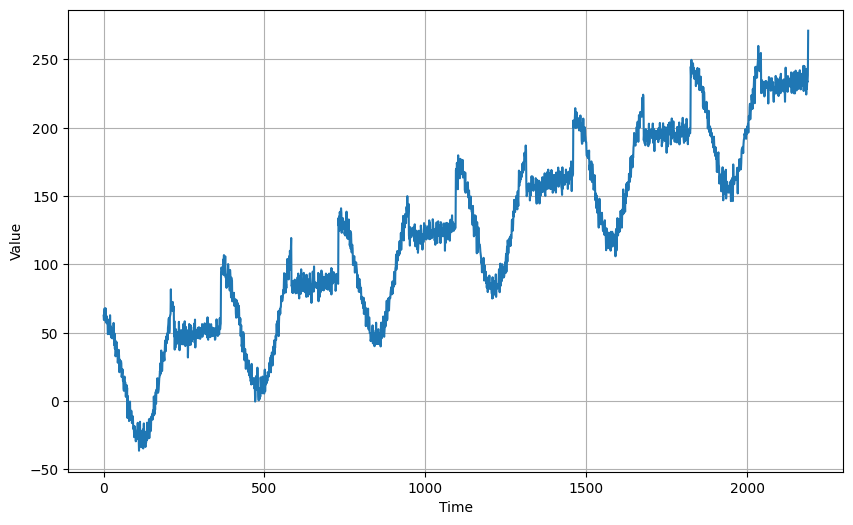

In [ ]:
time = np.arange(6 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 50
slope = 0.1
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, we can split it into training and validation data and start forecasting.

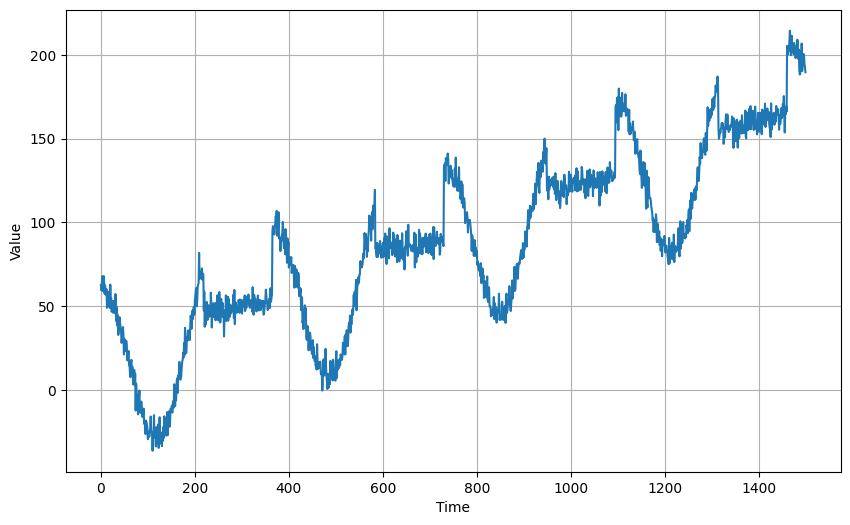

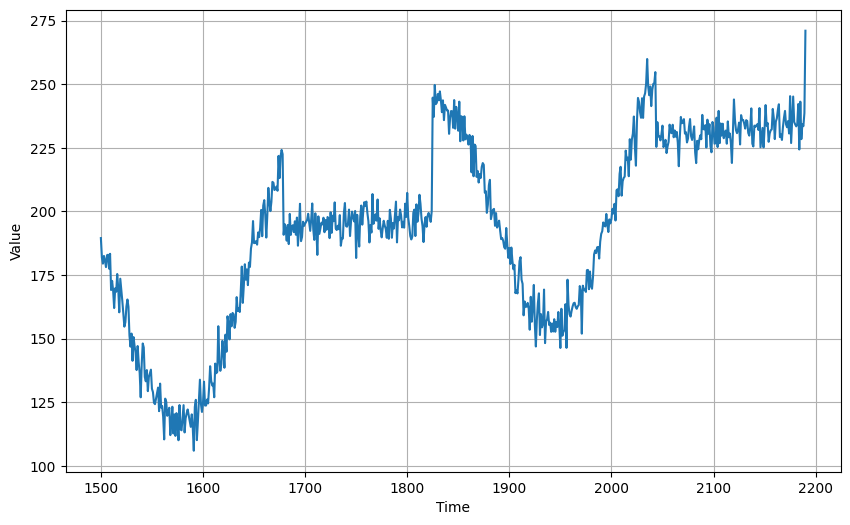

In [4]:
split_time = 1500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Naive Forecast

Naive forecasting uses the actual observed value from the last period as the forecast for the next period.

In [ ]:
naive_forecast = series[split_time - 1:-1]

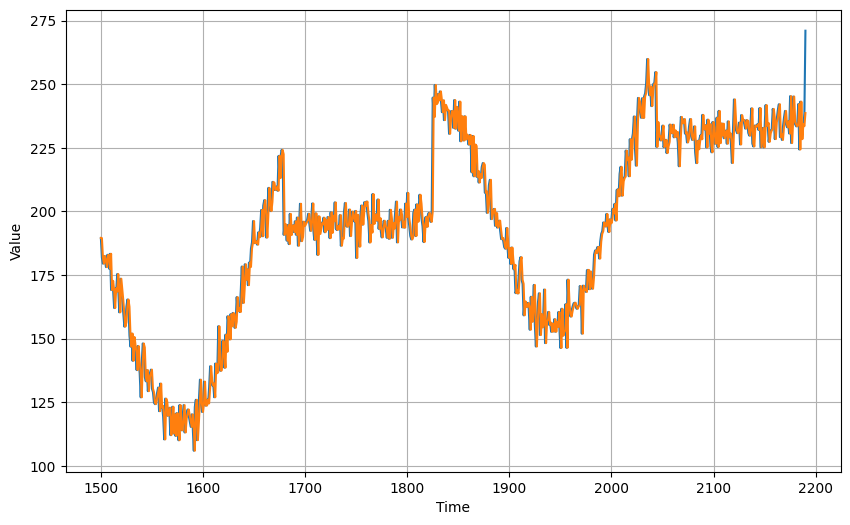

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

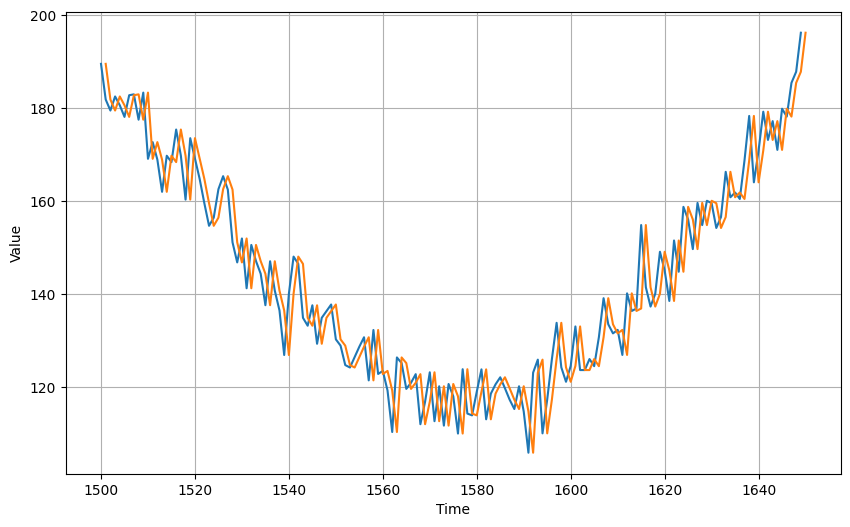

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

55.495823
5.701095


That's our baseline, now let's try a moving average.

## Moving Average (MA) Forecast

In [107]:
#Forecasts the mean of the last few values defined with window_size.
# If window_size=1, then this will be equivalent to naive forecast

def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

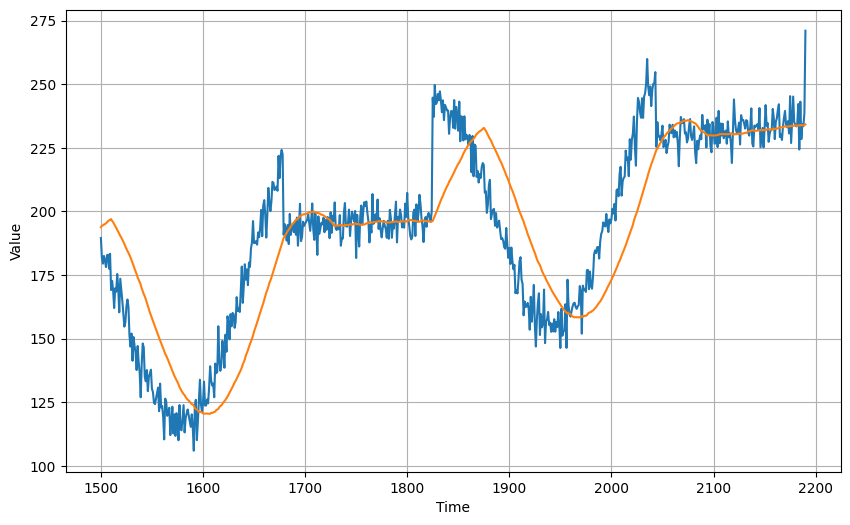

In [ ]:
moving_avg = moving_average_forecast(series, 50)[split_time - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

375.5134
14.845217


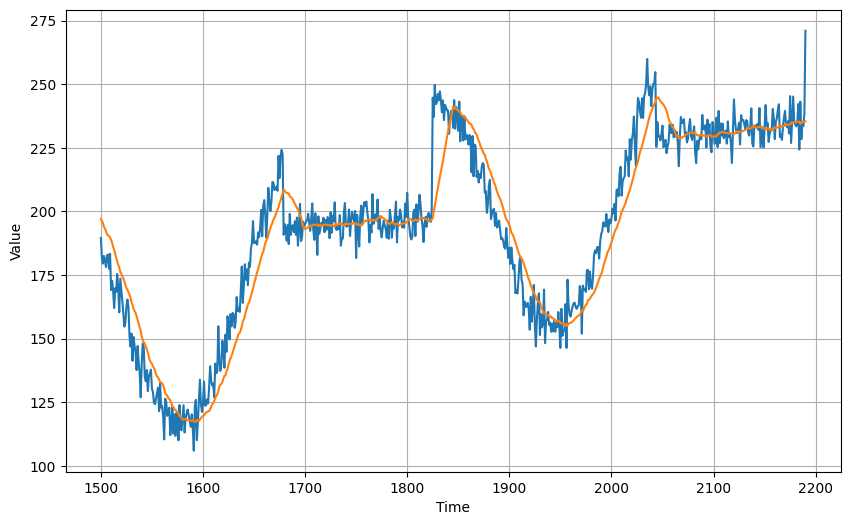

In [ ]:
moving_avg = moving_average_forecast(series, 20)[split_time - 20:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

115.98236
8.337615


Forecasting based on moving averaged gives worse results than naive forecast! The moving average does not anticipate trend or seasonality. Let's try to remove them by using method of differencing. The seasonality period is 365 days, so we can subtract the value at time *t* – 365 from the value at time *t*.

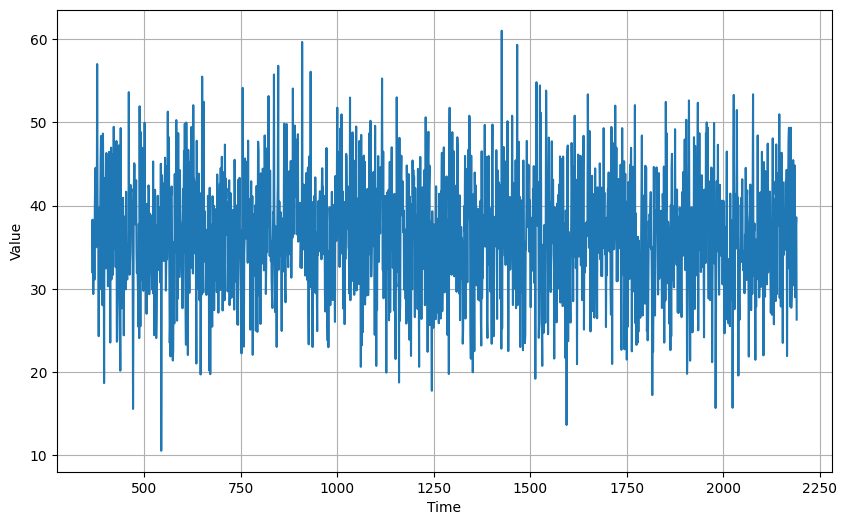

In [9]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Differencing based on seasonality helped to stabilise the mean of a time series, and eliminated seasonailty and reduced trend.
Now the moving average can be applied to differenced time-series.



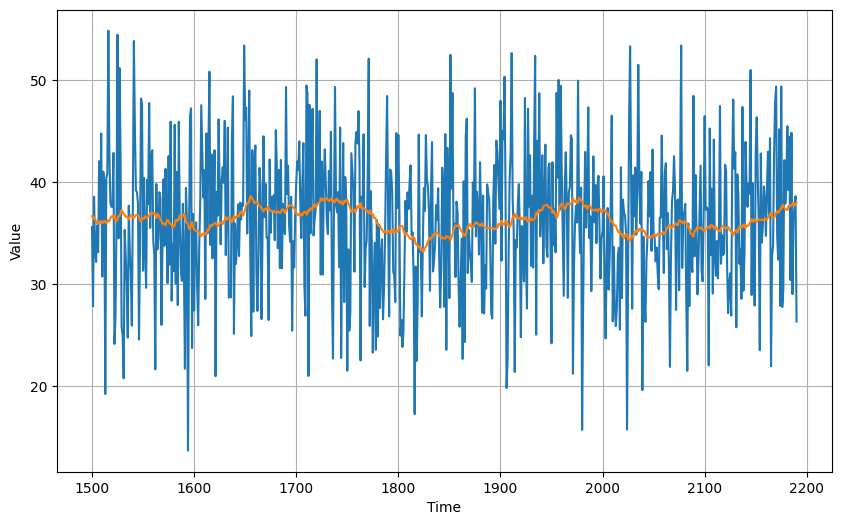

In [110]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

To transform differenced data into original dataset, the trend and seasonality needs to be returned by adding the past values from t – 365:

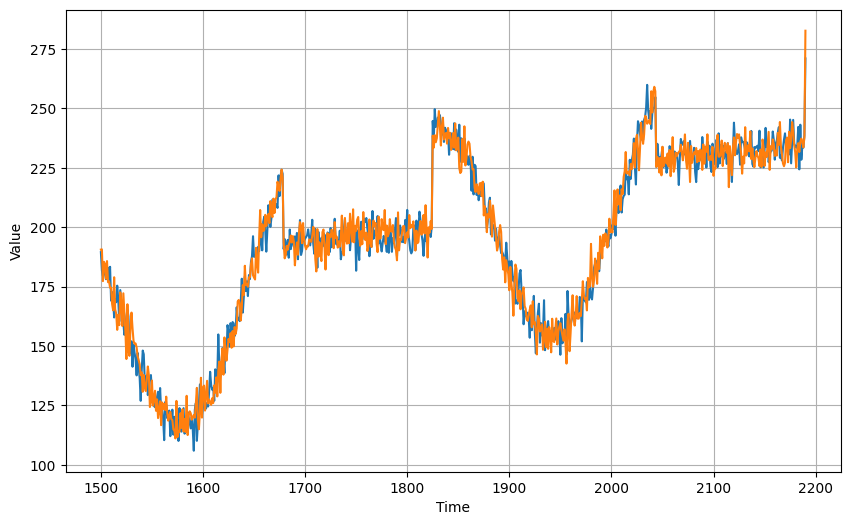

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

50.568565
5.629698


The results are betten than for naive forecast. However the forecasts look a bit too noisy, because past values were added, which were noisy too. Let's use a moving averaging on past 10 values to remove some of the noise and get smoother seasonal and trend signal, which will be added to the forecasted differenced time-series.

In [108]:
moving_ave_results = moving_average_forecast(series[split_time - 370:-360], 10)

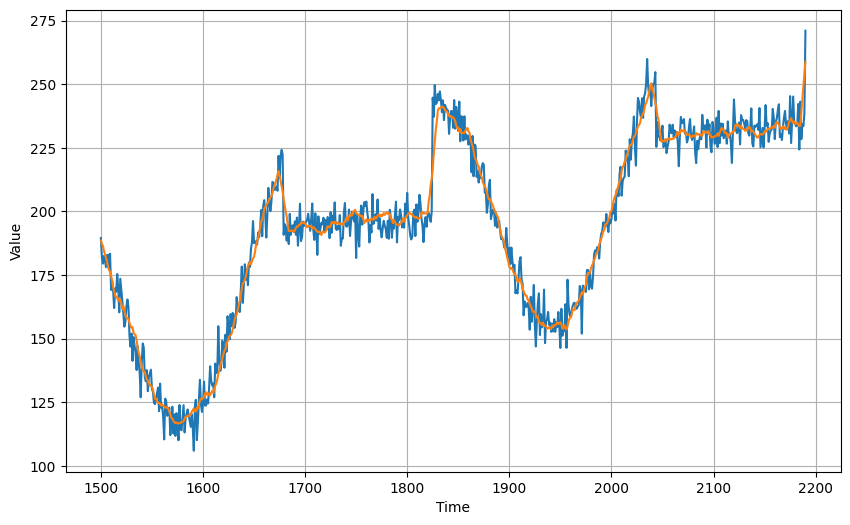

In [111]:
diff_moving_avg_plus_smooth_past = moving_ave_results + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.05941
4.4437785


Now results are much better, than previous one.

## **Linear Regression**

Firstly, dataset will be partitioned into subsections or windows (which increases the dimension shape of the dataset).

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
window_size = 30
batch_size = 50
shuffle_buffer_size = 1000

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [8]:
dataset_valid = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(dataset_valid)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [10]:
x_train_diff = diff_series[: split_time - 365]
x_valid_diff = diff_series[split_time - 365:]

In [11]:
dataset_train_diff = windowed_dataset(x_train_diff, window_size, batch_size, shuffle_buffer_size)
dataset_valid_diff = windowed_dataset(x_valid_diff, window_size, batch_size, shuffle_buffer_size)

In [ ]:
#Linear regression compiling and fitting
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])  #linear regression
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)) #stochastic gradient descent
model.fit(dataset,epochs=100,verbose=0) #run for 100 epochs (iterations), ignoring epoch by epoch output by setting verbose=0

print("Layer weights {}".format(l0.get_weights())) #inspect weights

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Layer weights [array([[-0.02630849],
       [ 0.00522296],
       [ 0.02560232],
       [-0.02889662],
       [ 0.04005104],
       [-0.04189156],
       [-0.05439657],
       [ 0.0125979 ],
       [ 0.03816177],
       [-0.00135146],
       [-0.00148386],
       [-0.04957929],
       [ 0.01547707],
       [-0.01585282],
       [ 0.05688785],
       [-0.03892794],
       [ 0.05959651],
       [-0.01645643],
       [-0.01206995],
       [-0.02712433],
       [-0.0216208 ],
       [ 0.02818176],
       [ 0.01183958],
       [-0.02188675],
       [ 0.04978246],
       [ 0.00892538],
       [ 0.09625494],
       [ 0.20512144],
       [ 0.32575533],
       [ 0.3732551 ]], dtype=float32), array([0.01528658], dtype=float32)]


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

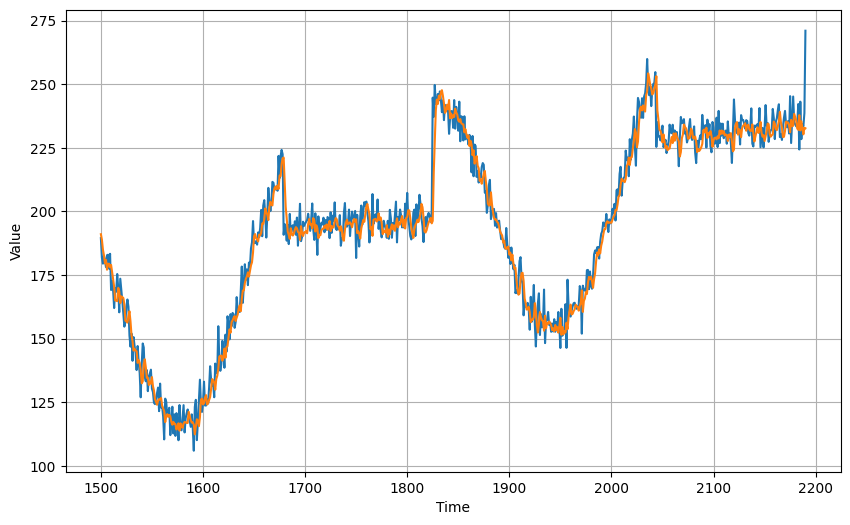

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.56772
4.988932


Training with differenced data (removed seasonality and reduced trend).

In [12]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])  #linear regression
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)) #stochastic gradient descent
model.fit(dataset_train_diff,epochs=100,verbose=0)

In [ ]:
forecast = []
for time in range(len(diff_series) - window_size):
  forecast.append(model.predict(diff_series[time:time + window_size][np.newaxis]))

Transforming differenced data into original dataset, by adding the past values from t – 365:

In [101]:
forecast_fin = forecast[split_time-window_size-365:]
results = np.array(forecast_fin)[:, 0, 0]
results_diff = results + series[split_time-365: -365]

Smoothing noise of transformed differenced data:

In [119]:
forecast_fin = forecast[split_time-window_size-365:]
results = np.array(forecast_fin)[:, 0, 0]
results_diff_smooth = results + moving_ave_results

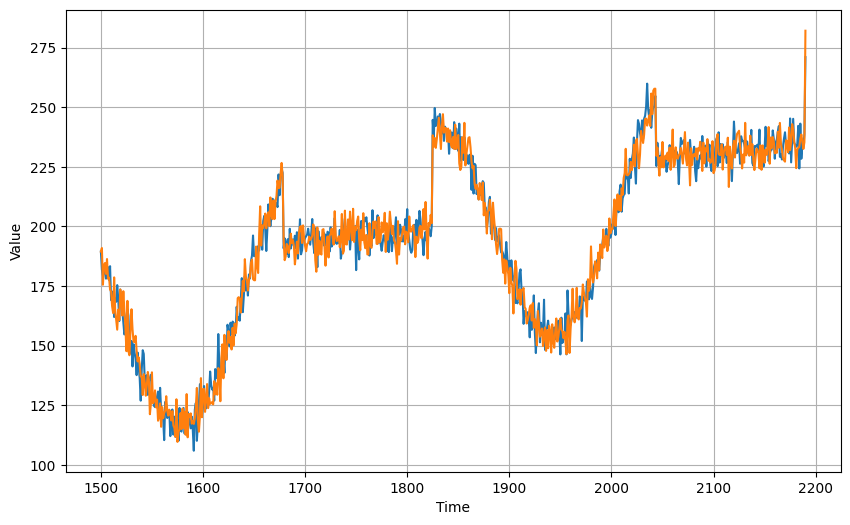

In [103]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results_fin_diff)

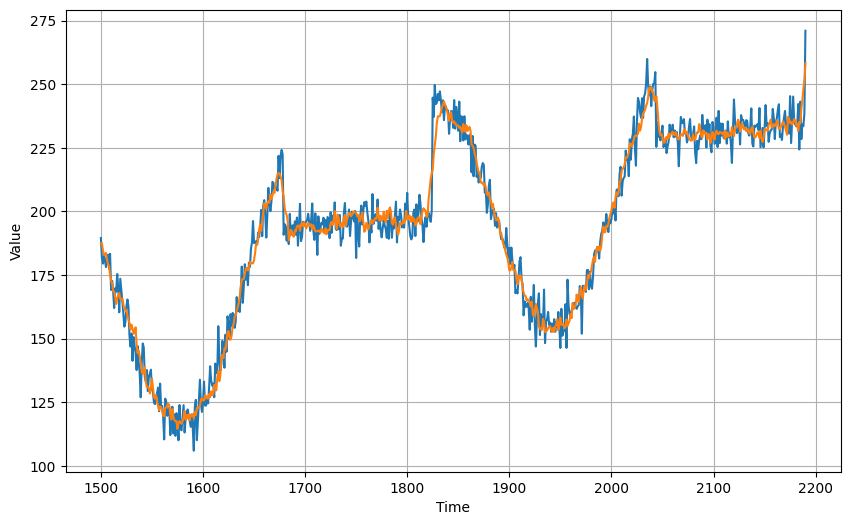

In [118]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results_fin_smooth)

In [105]:
print(keras.metrics.mean_squared_error(x_valid, results_diff).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results_diff).numpy())

51.109646
5.653167


In [120]:
print(keras.metrics.mean_squared_error(x_valid, results_diff_smooth).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results_diff_smooth).numpy())

34.95089
4.555035


## **Deep Neural Network (DNN)**

In [ ]:
#Deep Neural Network (DNN) with two hidden layers
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, validation_data=dataset_valid, epochs=100,verbose=0)

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 20)                620       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

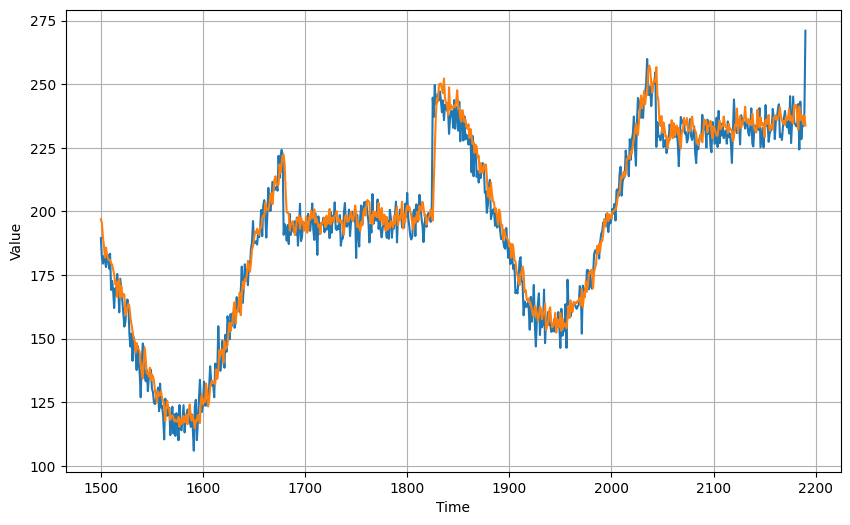

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

51.196487
5.3685284


In [ ]:
# Search for an optimal learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

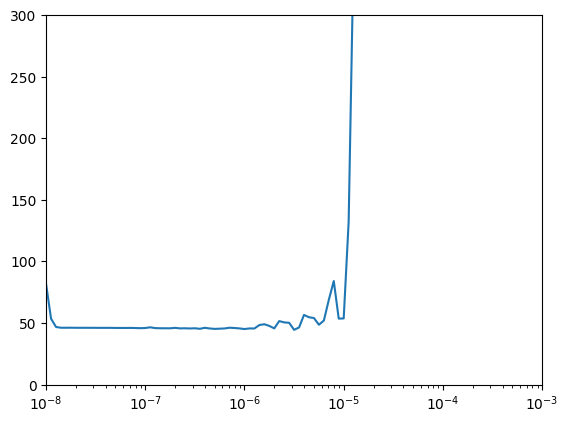

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

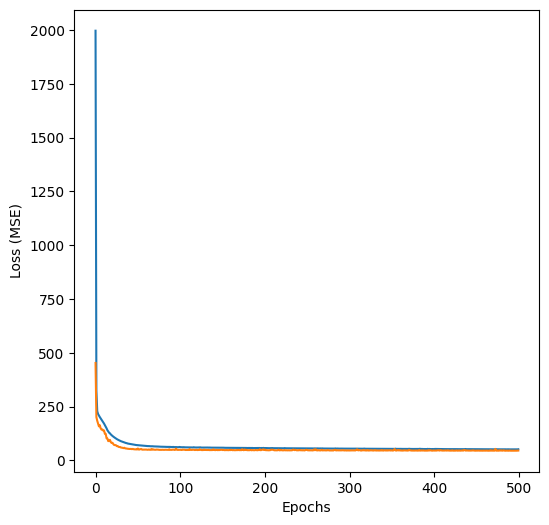

In [ ]:
# summarize history for loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = range(len(train_loss))
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

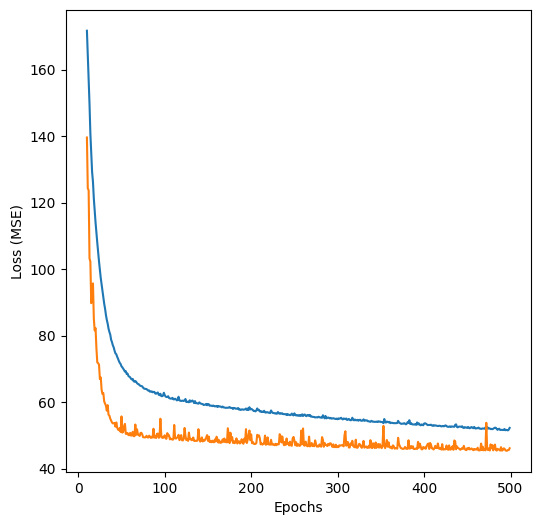

In [ ]:
# Plot all except the first 10
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = range(10, len(train_loss))
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_loss[10:], label='Training Loss')
plt.plot(epochs, valid_loss[10:], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

## **Long Short-Term Memory (LSTM)**

Let's try a fully connected bidirectional LSTM, where the output of the previous timestep is fed into the next timestep and the input flows in both directions. Thus, is able to use information from both sides so that the output layer can receive information from past and future states simultaneously.

In [137]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mae"])
    
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
30/30 [==============================] - 7s 12ms/step - loss: 3467.8989 - mae: 45.9943 - lr: 1.0000e-08
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 1758.0542 - mae: 33.4580 - lr: 1.1220e-08
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 1525.2538 - mae: 32.4662 - lr: 1.2589e-08
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 1373.8202 - mae: 30.7585 - lr: 1.4125e-08
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 1215.7565 - mae: 28.5623 - lr: 1.5849e-08
Epoch 6/100
30/30 [==============================] - 0s 12ms/step - loss: 1101.7820 - mae: 27.0361 - lr: 1.7783e-08
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 1001.2743 - mae: 25.8110 - lr: 1.9953e-08
Epoch 8/100
30/30 [==============================] - 0s 12ms/step - loss: 899.3909 - mae: 24.3865 - lr: 2.2387e-08
Epoch 9/100
30/30 [==============================] - 0s 12ms/step - loss:

(1e-09, 0.001, 0.0, 3000.0)

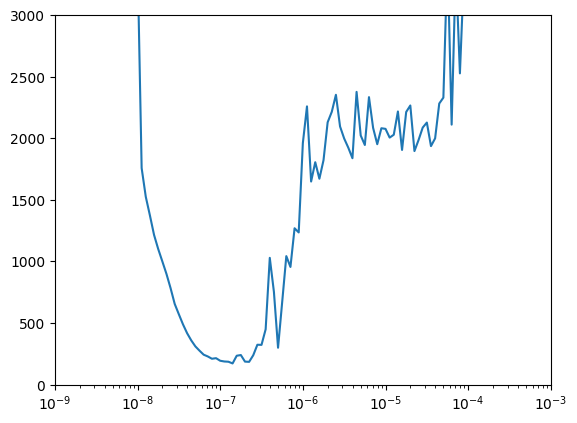

In [141]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9, 1e-3, 0, 3000])

In [142]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), 
              metrics=["mae"])
history = model.fit(dataset, epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 12ms/step - loss: 1665.6305 - mae: 33.7705
Epoch 2/500
30/30 [==============================] - 0s 12ms/step - loss: 1124.7238 - mae: 27.9361
Epoch 3/500
30/30 [==============================] - 0s 12ms/step - loss: 707.9925 - mae: 21.8033
Epoch 4/500
30/30 [==============================] - 1s 17ms/step - loss: 485.6648 - mae: 17.7315
Epoch 5/500
30/30 [==============================] - 1s 20ms/step - loss: 324.4890 - mae: 14.2107
Epoch 6/500
30/30 [==============================] - 1s 19ms/step - loss: 253.4092 - mae: 12.4909
Epoch 7/500
30/30 [==============================] - 0s 12ms/step - loss: 235.7845 - mae: 12.0301
Epoch 8/500
30/30 [==============================] - 0s 12ms/step - loss: 213.6052 - mae: 11.3755
Epoch 9/500
30/30 [==============================] - 0s 11ms/step - loss: 222.5985 - mae: 11.6623
Epoch 10/500
30/30 [==============================] - 0s 12ms/step - loss: 212.9957 - mae: 11.4775
Epoch 11/500
30/3

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

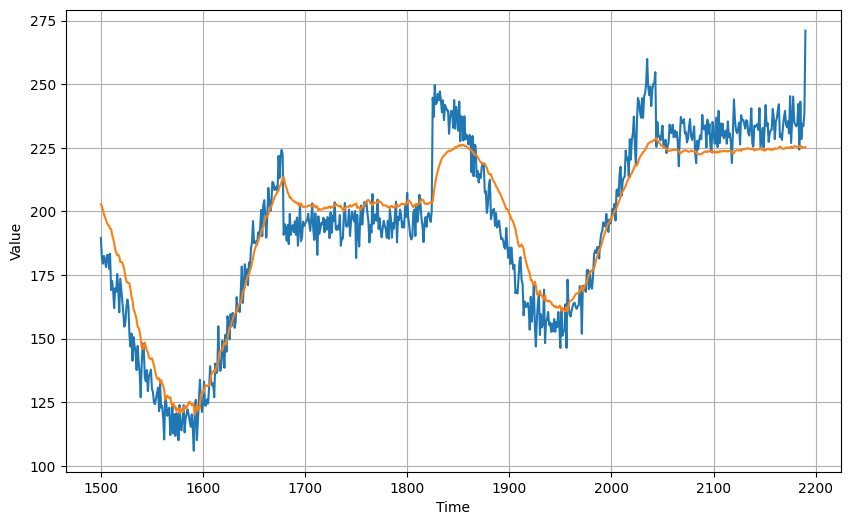

In [144]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [145]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

124.64827
8.971767


Let's try to incerase number of neurons to 200 in each LSTM layer.

In [156]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
  tf.keras.layers.Dense(1, activation='relu'),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), 
              metrics=["mae"])
history = model.fit(dataset, validation_data=dataset_valid, epochs=500)

Epoch 1/500
30/30 [==============================] - 10s 69ms/step - loss: 908.6064 - mae: 23.1055 - val_loss: 1798.6257 - val_mae: 35.9752
Epoch 2/500
30/30 [==============================] - 1s 23ms/step - loss: 202.8320 - mae: 11.2058 - val_loss: 811.1267 - val_mae: 23.3661
Epoch 3/500
30/30 [==============================] - 1s 18ms/step - loss: 149.1160 - mae: 9.3290 - val_loss: 826.5875 - val_mae: 23.5902
Epoch 4/500
30/30 [==============================] - 1s 24ms/step - loss: 134.7306 - mae: 8.8797 - val_loss: 546.3930 - val_mae: 18.6599
Epoch 5/500
30/30 [==============================] - 1s 24ms/step - loss: 120.3070 - mae: 8.1784 - val_loss: 593.9888 - val_mae: 19.6220
Epoch 6/500
30/30 [==============================] - 1s 30ms/step - loss: 108.7217 - mae: 7.6342 - val_loss: 490.3444 - val_mae: 17.6093
Epoch 7/500
30/30 [==============================] - 1s 19ms/step - loss: 101.7912 - mae: 7.3685 - val_loss: 452.3814 - val_mae: 16.8730
Epoch 8/500
30/30 [==================

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

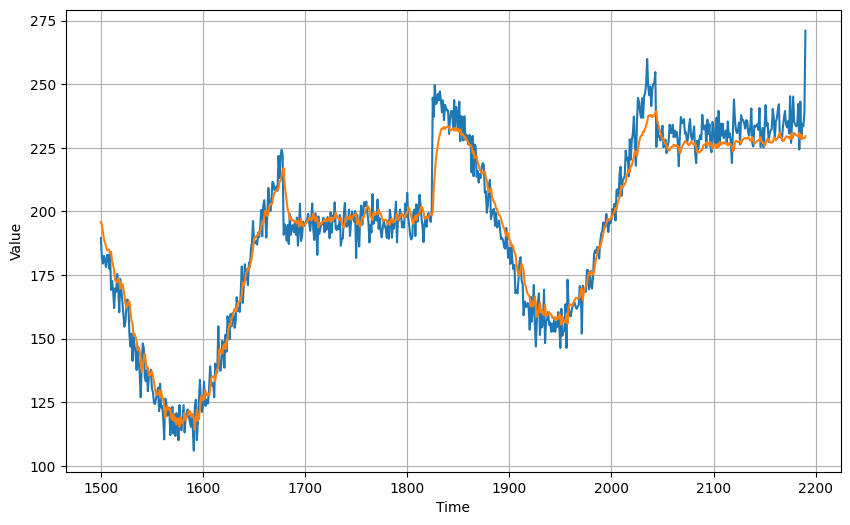

In [158]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [159]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

58.482296
5.827294


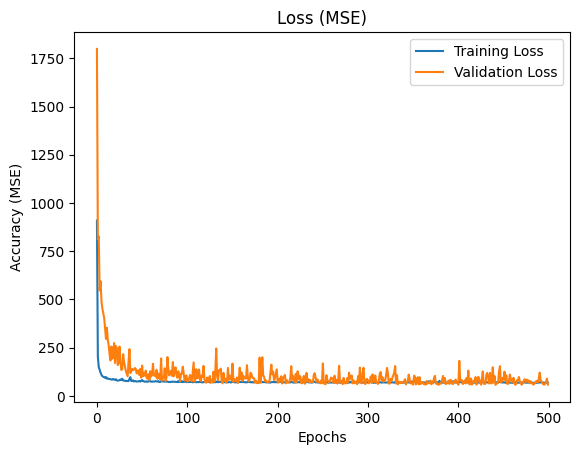

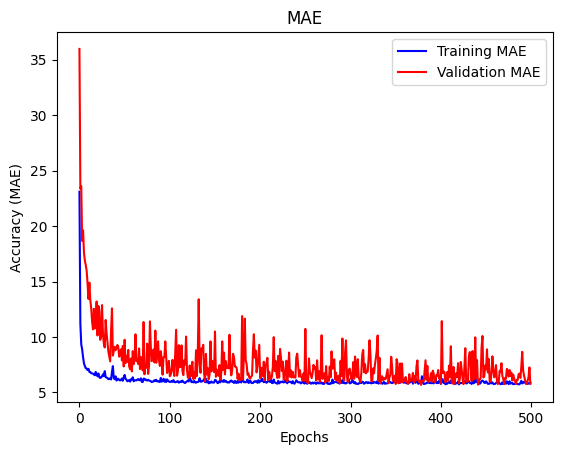

In [160]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and validation data sets for each training epoch
#-----------------------------------------------------------
train_mae=history.history['mae']
valid_mae=history.history['val_mae']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs=range(len(train_loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.title('Loss (MSE)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (MSE)")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

plt.figure()
plt.plot(epochs, train_mae, 'b')
plt.plot(epochs, valid_mae, 'r')
plt.title('MAE')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (MAE)")
plt.legend(["Training MAE", "Validation MAE"])